# Hyperparameters (except number of hidden layers)
#### 1. Hyperparams of neural network structure

In [17]:
num_neuron_layer=1000 #number of hidden neurons in each layer in the fully connected layers
activ_func="ReLU" #activation functions, can be "ReLU","Tanh"
dropout_percent=0.4 #percentage dropped out in DropOut regularization in model class

# num_conv_layers=2 #number of convolutional layers (count a pair of 1 conv2d plus 1 pooling layer as 1 layer)
kwargs_conv1={"in_channels":3, "out_channels":32, "kernel_size":3, "stride":1, "padding":1}
kwargs_conv2={"in_channels":32, "out_channels":64, "kernel_size":3, "stride":1, "padding":1}
kwargs_conv3={"in_channels":64, "out_channels":128, "kernel_size":3, "stride":1, "padding":1}
#kwargs_conv4={"in_channels":64, "out_channels":128, "kernel_size":3, "stride":1, "padding":1}

maxpool1_size=2
maxpool2_size=2
maxpool3_size=2
maxpool4_size=2

#### 2. Other hyperparams

In [18]:
batch_size = 50 #number of samples in each batch
learn_rate=0.1 #learning rate
momentum=0 #optimizer momentum

use_default_norm=True #use default normalization of DataLoader or not
norm_mean=0.05 #normalization mean in DataLoader
norm_std=1 #normalization std in DataLoader

final_epochs=15 #number of training epochs used for training the final model
valid_epochs=15 #number of training epochs used in each round of cross-validation
l1_reg_weight=0 #weight of L1 regularization
l2_reg_weight=0.002 #weight of L2 regularization
lr_decay=0 #specific for Adagrad optimizer
k = 5 #number of total cross-validations
optim_type="SGD" #type of optimizer, can be "SGD","Adam","Adagrad","Adadelta","RMSprop"



#### Function used for creating new optimizer according to the predefined hyperparams

In [19]:
def new_optim(model, optim_type=optim_type, learn_rate=learn_rate, momentum=momentum, 
              l2_reg_weight=l2_reg_weight, lr_decay=lr_decay):

    if optim_type=="SGD":
        optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum, weight_decay=l2_reg_weight)
        # momentum helps accelerate SGD in the relevant direction and dampens oscillations.
        # It does this by adding a fraction γ of the update vector of the past time step to the current update vector
    elif optim_type=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=l2_reg_weight)
    elif optim_type=="Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learn_rate, lr_decay=lr_decay, weight_decay=l2_reg_weight)
    elif optim_type=="Adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=learn_rate, weight_decay=l2_reg_weight)
    elif optim_type=="RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learn_rate, momentum=momentum, weight_decay=l2_reg_weight)
    
    return optimizer

In [20]:
import sys
print(sys.version)
import torch
print(torch)

2.7.12 (default, Nov 20 2017, 18:23:56) 
[GCC 5.4.0 20160609]
<module 'torch' from '/usr/local/lib/python2.7/dist-packages/torch/__init__.pyc'>


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets as dsets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import Sampler

import numpy as np
from numpy.random import shuffle
import matplotlib.pyplot as plt #in cuda 8, need to "export LC_ALL=en_US.UTF-8" in locale first, or this line will result in error
from numpy.random import seed

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

torch.manual_seed(31)
if cuda:
    torch.cuda.manual_seed(31)
    # Does this line work if it's not right before the random method?

('Using PyTorch version:', '0.1.12_2', 'CUDA:', True)


## 1. Load CIFAR data

In [22]:
if use_default_norm==False:
    trainset = dsets.CIFAR10('./data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((norm_mean,), (norm_std,))
                             ]))
    testset = dsets.CIFAR10('./data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((norm_mean,), (norm_std,))
                            ]))
    
else: 
    trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor(),) #use default normalization
    # transforms.ToTensor: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

    testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor(),)



Files already downloaded and verified
Files already downloaded and verified


### Structure of data in train_loader: X_train is the pixel data, y_train is the labels

In [23]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size, shuffle=False, **kwargs) 
test_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size, shuffle=True, **kwargs)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

('X_train:', torch.Size([50, 3, 32, 32]), 'type:', 'torch.FloatTensor')
('y_train:', torch.Size([50]), 'type:', 'torch.LongTensor')


### Get input and output dimensions of dataset

In [24]:
(a,b,c)=trainset[0][0].numpy().shape
input_dim = a*b*c #RGB
img_dim=b #the length of one side of the image
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output_dim = len(CLASSES) #10 different classes


## 2. Create model class and instantiate loss function

### Functions used for plotting the feature maps

In [25]:
def resize_pixel_value(pixel_value,old_mean,old_sd): #change the pixel value to range(0,256)
    new_value=(pixel_value-old_mean)/(3*old_sd)*128+128
    if new_value<256 and new_value>=0:
        return int(new_value)
    elif new_value>=256:
        return 255
    else:
        return 0
v_resize_pixel_value=np.vectorize(resize_pixel_value) #to be able to apply element-wise on numpy array

In [26]:
def plot_feature_maps(num_filter,means_feature_map,sds_feature_map,output,layer_index=0,type="before_relu",pltsize=2):
    plt.figure(figsize=(num_filter/4*pltsize, pltsize*4))
    if type=="before_relu":
        #plt.suptitle("Conv layer {}: feature maps before ReLU".format(layer_index), fontsize=30)
        print("Conv layer {}: feature maps before ReLU:".format(layer_index))
    elif type=="after_relu":
        #plt.suptitle("Conv layer {}: feature maps after ReLU".format(layer_index), fontsize=30)
        print("Conv layer {}: feature maps after ReLU".format(layer_index))
    elif type=="after_pooling":
        #plt.suptitle("Conv layer {}: feature maps after pooling".format(layer_index), fontsize=18)      
        print("Conv layer {}: feature maps after pooling".format(layer_index))      

    for i in range(num_filter): #out.data.cpu()[0]: the 32 different feature maps generated by the first conv layer
        img=output.data.cpu()[0][i] #output is a torch Variable, on GPU
        img_np=img.numpy()
        img_for_plot=v_resize_pixel_value(img_np,means_feature_map[i],sds_feature_map[i]) #map each element to range(0,256), in order to plot a grayscale figure of it

        plt.subplot(4,num_filter/4,i+1)
        plt.axis('off')
        if type=="after_pooling":
            plt.title(i,y=0.95)
        else: plt.title(i)
        plt.imshow(img_for_plot,cmap='gray',vmin=0,vmax=255)
    plt.show()

### Model class with ReLU

In [27]:
if activ_func=="ReLU":
    class CNNModel(nn.Module):
        def __init__(self): #show the first image and its feature maps in the convolutional neural network
            super(CNNModel, self).__init__()
            #self.show_first_in_batch=show_first_in_batch
            
            # Convolution 1
            self.cnn1 = nn.Conv2d(**kwargs_conv1)
            new_dim=img_dim+2*kwargs_conv1["padding"]-kwargs_conv1["kernel_size"]+1 #the new dimension (dimension of feature map)

            # Max pool 1
            self.maxpool1 = nn.MaxPool2d(kernel_size=maxpool1_size)
            new_dim/=maxpool1_size
            
            # Convolution 2
            self.cnn2 = nn.Conv2d(**kwargs_conv2)
            new_dim=new_dim+2*kwargs_conv2["padding"]-kwargs_conv2["kernel_size"]+1 #the new dimension (dimension of feature map)

            # Max pool 2
            self.maxpool2 = nn.MaxPool2d(kernel_size=maxpool2_size)
            new_dim/=maxpool2_size
            
            # Convolution 3
            self.cnn3 = nn.Conv2d(**kwargs_conv3)
            new_dim=new_dim+2*kwargs_conv3["padding"]-kwargs_conv3["kernel_size"]+1 #the new dimension (dimension of feature map)

#             # Max pool 3
#             self.maxpool3 = nn.MaxPool2d(kernel_size=maxpool3_size)
#             new_dim/=maxpool3_size
            
#             # Convolution 4
#             self.cnn4 = nn.Conv2d(**kwargs_conv4)
#             new_dim=new_dim+2*kwargs_conv4["padding"]-kwargs_conv4["kernel_size"]+1 #the new dimension (dimension of feature map)

#             # Max pool 4
#             self.maxpool4 = nn.MaxPool2d(kernel_size=maxpool4_size)
#             new_dim/=maxpool4_size
            

            # Fully connected 1 (readout)
            self.fc1 = nn.Linear(kwargs_conv3["out_channels"] * new_dim * new_dim, num_neuron_layer) ###need to change when changing number of conv layers
            self.fc1_drop = nn.Dropout(dropout_percent) #Drop out regularization
            self.fc2=nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc2_drop = nn.Dropout(dropout_percent)
            self.fc3=nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc3_drop = nn.Dropout(dropout_percent)
            
            self.fc4=nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc4_drop = nn.Dropout(dropout_percent)
#             self.fc5=nn.Linear(num_neuron_layer, num_neuron_layer)
#             self.fc5_drop = nn.Dropout(dropout_percent)
            
            self.fc5=nn.Linear(num_neuron_layer, 10)
            
            
            self.relu= nn.ReLU()

        def forward(self, x):
            # x =  torch.Size([100, 3, 32, 32])
            # Convolution 1
            out = self.cnn1(x) #torch.Size([100, 16, 28, 28])
            out = self.relu(out) #torch.Size([100, 16, 28, 28])

            # Max pool 1
            out = self.maxpool1(out)#torch.Size([100, 16, 14, 14])

            # Convolution 2 
            out = self.cnn2(out) #torch.Size([100, 32, 10, 10])
            out = self.relu(out) #torch.Size([100, 32, 10, 10])

            # Max pool 2 
            out = self.maxpool2(out)#torch.Size([100, 32, 5, 5])
            
            # Convolution 3 
            out = self.cnn3(out)
            out = self.relu(out)

#             # Max pool 3 
#             out = self.maxpool3(out)
            
#             # Convolution 4 
#             out = self.cnn4(out) 
#             out = self.relu(out)

#             # Max pool 4 
#             out = self.maxpool4(out)

            # Resize
            # out.size(0): 100
            out = out.view(out.size(0), -1)

            # Linear function (readout)
            out = self.fc1(out)
            out = self.relu(out)
            out = self.fc1_drop(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc2_drop(out)
            out = self.fc3(out)
            out = self.relu(out)
            out = self.fc3_drop(out)
            
            out = self.fc4(out)
            out = self.relu(out)
            out = self.fc4_drop(out)
#             out = self.fc5(out)
#             out = self.relu(out)
#             out = self.fc5_drop(out)

            return self.fc5(out)

        def forward_imshow(self, x): #give an input image to the model and show the feature maps generated by it
            # x =  torch.Size([1, 3, 32, 32])
            
            # Convolution 1
            out = self.cnn1(x) #torch.Size([1, 32, 32, 32])
            num_filter=len(out.data.cpu()[0]) #number of filters of the current conv layer (same with relus and pooling)
            means_feature_map=np.zeros(num_filter)  # store the mean value of pixels of each feature map
            sds_feature_map=np.zeros(num_filter)  # store the std of pixel values of each feature map           
            for i in range(num_filter): #out.data.cpu()[0]: the 32 different feature maps generated by the first conv layer
                img=out.data.cpu()[0][i]
                img_np=img.numpy()
                means_feature_map[i]=np.mean(img_np)
                sds_feature_map[i]=np.std(img_np)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=1,type="before_relu",pltsize=2)
            
            out = self.relu(out)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=1,type="after_relu",pltsize=2)
          
            # Max pool 1
            out = self.maxpool1(out)    
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=1,type="after_pooling",pltsize=1)

            # Convolution 2 
            out = self.cnn2(out)             
            num_filter=len(out.data.cpu()[0]) #number of filters of the current conv layer (same with relus and pooling)
            means_feature_map=np.zeros(num_filter)  # store the mean value of pixels of each feature map
            sds_feature_map=np.zeros(num_filter)  # store the std of pixel values of each feature map
            for i in range(num_filter): #out.data.cpu()[0]: the 32 different feature maps generated by the first conv layer
                img=out.data.cpu()[0][i]
                img_np=img.numpy()
                means_feature_map[i]=np.mean(img_np)
                sds_feature_map[i]=np.std(img_np)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=2,type="before_relu",pltsize=2)

            out = self.relu(out)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=2,type="after_relu",pltsize=2)

            # Max pool 2 
            out = self.maxpool2(out)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=2,type="after_pooling",pltsize=1)

            
            # Convolution 3 
            out = self.cnn3(out)
            num_filter=len(out.data.cpu()[0]) #number of filters of the current conv layer (same with relus and pooling)
            means_feature_map=np.zeros(num_filter)  # store the mean value of pixels of each feature map
            sds_feature_map=np.zeros(num_filter)  # store the std of pixel values of each feature map
            for i in range(num_filter): #out.data.cpu()[0]: the 32 different feature maps generated by the first conv layer
                img=out.data.cpu()[0][i]
                img_np=img.numpy()
                means_feature_map[i]=np.mean(img_np)
                sds_feature_map[i]=np.std(img_np)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=3,type="before_relu",pltsize=2)
            
            out = self.relu(out)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=3,type="after_relu",pltsize=2)

            # Max pool 3 
            out = self.maxpool3(out)
            plot_feature_maps(num_filter,means_feature_map,sds_feature_map,out,layer_index=3,type="after_pooling",pltsize=1)
            
#             # Convolution 4 
#             out = self.cnn4(out) 
#             out = self.relu(out)

#             # Max pool 4 
#             out = self.maxpool4(out)

            # Resize
            # out.size(0): 100
            out = out.view(out.size(0), -1)

            # Linear function (readout)
            out = self.fc1(out)
            out = self.relu(out)
            out = self.fc1_drop(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc2_drop(out)
            out = self.fc3(out)
            out = self.relu(out)
            out = self.fc3_drop(out)
            
            out = self.fc4(out)
            out = self.relu(out)
            out = self.fc4_drop(out)
#             out = self.fc5(out)
#             out = self.relu(out)
#             out = self.fc5_drop(out)
            
            out=self.fc5(out)
            return 
        

### Model class with Tanh

In [28]:
if activ_func=="Tanh":
    class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()

            # Convolution 1
            self.cnn1 = nn.Conv2d(**kwargs_conv1)
            new_dim=img_dim-kwargs_conv1["kernel_size"]+1 #the new dimension (dimension of feature map)

            # Max pool 1
            self.maxpool1 = nn.MaxPool2d(kernel_size=maxpool1_size)
            new_dim/=maxpool1_size
            
            # Convolution 2
            self.cnn2 = nn.Conv2d(**kwargs_conv2)
            new_dim=new_dim-kwargs_conv2["kernel_size"]+1 #the new dimension (dimension of feature map)

            # Max pool 2
            self.maxpool2 = nn.MaxPool2d(kernel_size=2)
            new_dim/=maxpool2_size

            # Fully connected 1 (readout)
            self.fc1 = nn.Linear(kwargs_conv2["out_channels"] * new_dim * new_dim, num_neuron_layer) 
            # self.fc1_drop = nn.Dropout(dropout_percent)#Drop out regularization
            self.fc2=nn.Linear(num_neuron_layer, 10)
            
            self.tanh= nn.Tanh()

        def forward(self, x):
            # x =  torch.Size([100, 3, 32, 32])
            # Convolution 1
            out = self.cnn1(x) #torch.Size([100, 16, 28, 28])
            out = self.tanh(out) #torch.Size([100, 16, 28, 28])

            # Max pool 1
            out = self.maxpool1(out)#torch.Size([100, 16, 14, 14])

            # Convolution 2 
            out = self.cnn2(out) #torch.Size([100, 32, 10, 10])
            out = self.tanh(out) #torch.Size([100, 32, 10, 10])

            # Max pool 2 
            out = self.maxpool2(out)#torch.Size([100, 32, 5, 5])

            out = out.view(out.size(0), -1)  #torch.Size([100, 800])

            # Linear function (readout)
            out = self.fc1(out)
            out = self.tanh(out)
            out = self.fc2(out)

            return out

## 3. Instantiate loss function

In [29]:
#loss function:
criterion = nn.CrossEntropyLoss() 
#CrossEntropyLoss: This criterion combines LogSoftMax and NLLLoss in one single class.
if cuda: #use GPU
    criterion = criterion.cuda()

## 4. Learning: training, test and results printing
### Training and validation function: k-fold validation
Define a sampler for cross validation

In [30]:
class CrossValidSampler(Sampler):
    def __init__(self, data, valid_round=1,valid_folds=1, rand_seed=1, if_valid=False):      
        self.num_samples = len(data)
        self.valid_round=valid_round #valid_round: the index of the validation round (from 1 to valid_folds); 
        self.rand_seed=rand_seed #rand_seed: random seed is an integer, to make sure each cross-validation round use exclusive portion of the dataset
        self.valid_folds=valid_folds #valid_folds: number of total cross validations (e.g. k in k-fold cross validation)
        self.if_valid=if_valid #Boolean: if this is a sampler for validation set (True) or training set (False)

    def __iter__(self):
        seed(self.rand_seed) #To make the result reproducible for all rounds of cross validations
        all_indices=range(self.num_samples)
        shuffle(all_indices) #randomly shuffle the indices
        valid_size=self.num_samples//self.valid_folds #number of samples in the validation set
        if self.if_valid==False: #a sampler for training set
            return iter(all_indices[:(self.valid_round-1)*valid_size] + all_indices[self.valid_round*valid_size:])
        else: #a sampler for validation set
            return iter(all_indices[(self.valid_round-1)*valid_size : min(self.valid_round*valid_size, self.num_samples)])

    def __len__(self):
        valid_size=self.num_samples//self.valid_folds #number of samples in the validation set
        if self.if_valid==False: #a sampler for training set
            return self.num_samples-valid_size
        else: return valid_size


In [31]:
def k_fold_cross_valid(epochs, k, loss_matrix, accuracy_matrix, rand_seed=22, log_interval=100): 
    """training and validation together: in each round of cross-validation, there are epochs training epoch
    epochs: the total number of epochs, k is the total number of validation rounds
    loss_matrix, accuracy_matrix: one row is one cross-validation, one column is one epoch
    rand_seed: to make the result reproducible"""
    
    
    for k_idx in range(1,k+1): #one round of cross validation
        print("{}-th cross-validation: \n".format(k_idx))

        #Build a new model for this round of cross-validation
        # model = NeuroNet(input_dim, output_dim) #instantiate a new model for each round of cross-validation
        model = CNNModel() #instantiate a new model for each round of cross-validation

        if cuda: #use GPU for model
            model.cuda()

        #create a new optimizer for this round of cross-validation
        optimizer = new_optim(model)
        
        #use sampler to sample the data
        #because sampler is an iterator, so need to create again once it has reached the end
        CV_sampler_train=CrossValidSampler(trainset, valid_round=k_idx, valid_folds=k, rand_seed=rand_seed, if_valid=False)
        CV_sampler_valid=CrossValidSampler(trainset, valid_round=k_idx, valid_folds=k, rand_seed=rand_seed, if_valid=True)
        train_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,sampler=CV_sampler_train, shuffle=False, **kwargs) 
        valid_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,sampler=CV_sampler_valid, shuffle=False, **kwargs) 
        
        iter_idx=0 #index of training iterations of each cross-validation

        for epoch in range(1, epochs + 1): #repeat epochs times

            """training phase"""
            model.train() #Sets the module in training mode. This has any effect only on modules such as Dropout or BatchNorm
                        
            for batch_idx, (data, target) in enumerate(train_loader): #get one batch in every iteration
                if cuda: #use GPU
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                optimizer.zero_grad() #clear previous gradients
                output = model(data)

                loss = criterion(output, target)
                if l1_reg_weight!=0:
                    """L1 regularization:"""
                    L1_crit=nn.L1Loss(size_average=False) #sum up pairwise absolute loss, instead of averaging
                    for param in model.parameters(): #for each parameter tensor
                        all_0_target=torch.zeros(param.size())
                        if cuda:
                            param,all_0_target=param.cuda(),all_0_target.cuda()
                        all_0_target=Variable(all_0_target)
                        #param=Variable(param) #param is already a Variable
                        loss+=L1_crit(param,all_0_target)*l1_reg_weight

                #for plotting loss in each iteration.        
                loss_mat_train[k_idx-1,iter_idx]=loss.data[0]
                
                #for plotting accuracy in each iteration
                pred = output.data.max(1)[1] 
                correct = pred.eq(target.data).cpu().sum() #The number of correct predictions of this batch
                accuracy = 100. * correct / batch_size #accuracy of this batch
                acc_mat_train[k_idx-1,iter_idx]=accuracy
        
                loss.backward() #Getting gradients w.r.t. parameters
                optimizer.step() #Update parameters

                if batch_idx % log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader)*len(data),
                        100. * batch_idx / len(train_loader), loss.data[0]))

                iter_idx+=1 #each batch: iteration index +1

            """Validation phase"""
            model.eval()#Sets the module in evaluation mode. This has any effect only on modules such as Dropout or BatchNorm

            valid_loss, correct = 0, 0

            for (data, target) in valid_loader: #get one batch in every iteration
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data, volatile=True), Variable(target, volatile=True) #volatile=True is more efficient when you won’t call .backward()

                output = model(data)
                valid_loss += criterion(output, target).data[0] #get data (Tensor) from variable, and get the first value of the Tensor
                pred = output.data.max(1)[1] # [1]: get the index of the max output (which corresponds to max log-probability), (1) means axis=1: row-wise max
                correct += pred.eq(target.data).cpu().sum() #The number of correct predictions: torch.eq() Computes element-wise equality

            valid_loss /= len(valid_loader) #Average loss among all test batches

            accuracy = 100. * correct / (len(valid_loader)*batch_size) #total number of correct predictions

            print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                valid_loss, correct, len(valid_loader)*batch_size, accuracy))

            loss_matrix[k_idx-1,epoch-1]=valid_loss #index starts with 0, but k_idx starts from 1
            accuracy_matrix[k_idx-1,epoch-1]=accuracy

        #delete the (local) model and optimizer to free some memory
        del model
        del optimizer

### Train and validate the model of CIFAR: cross validation
#### An epoch means one pass through the whole training data. In each epoch, instantiate a new model for training, and evaluate the model using validate

In [ ]:
%matplotlib inline

#valid_epochs already initialized in the beginning, as one of the hyperparameters
loss_mat=np.zeros((k,valid_epochs)) #one row is one cross-validation, one column is one epoch
acc_mat=np.zeros((k,valid_epochs))

#for plotting training accuracy together with validation accuracy
num_of_train_iters=valid_epochs*len(trainset)*(k-1)/k/batch_size
loss_mat_train=np.zeros((k,num_of_train_iters)) #one row is one cross-validation, one column is one iteration
acc_mat_train=np.zeros((k,num_of_train_iters))
train_iter_vector=np.arange(1,num_of_train_iters+1)
valid_iter_vector=np.arange(1*num_of_train_iters/valid_epochs,num_of_train_iters+1,num_of_train_iters/valid_epochs) #the index of training iteration when each test takes place


k_fold_cross_valid(valid_epochs, k, loss_mat, acc_mat, rand_seed=32)



1-th cross-validation: 

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.303277
Train Epoch: 1 [5000/40000 (12%)]	Loss: 2.300701
Train Epoch: 1 [10000/40000 (25%)]	Loss: 2.307086
Train Epoch: 1 [15000/40000 (38%)]	Loss: 2.306927
Train Epoch: 1 [20000/40000 (50%)]	Loss: 2.297314
Train Epoch: 1 [25000/40000 (62%)]	Loss: 2.313149
Train Epoch: 1 [30000/40000 (75%)]	Loss: 2.302327
Train Epoch: 1 [35000/40000 (88%)]	Loss: 2.308767

Validation set: Average loss: 2.3036, Accuracy: 996/10000 (10%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 2.299517
Train Epoch: 2 [5000/40000 (12%)]	Loss: 2.301209
Train Epoch: 2 [10000/40000 (25%)]	Loss: 2.303761
Train Epoch: 2 [15000/40000 (38%)]	Loss: 2.305450
Train Epoch: 2 [20000/40000 (50%)]	Loss: 2.296393
Train Epoch: 2 [25000/40000 (62%)]	Loss: 2.310650
Train Epoch: 2 [30000/40000 (75%)]	Loss: 2.301675
Train Epoch: 2 [35000/40000 (88%)]	Loss: 2.305206

Validation set: Average loss: 2.2834, Accuracy: 1447/10000 (14%)

Train Epoch: 3 [0/40000 (0%)]	Loss: 2.284270
Train Epo

#### Print the values of validation loss and accuracy in each cross-validation

In [43]:
lossv_last_epoch=loss_mat[:,valid_epochs-1].flatten() # loss vector containing the validation loss of the last epoch of each cross-validation
accv_last_epoch=acc_mat[:,valid_epochs-1].flatten() # accuracy vector containing the validation accuracy of the last epoch of each cross-validation
print("Final validation loss of each cross-validation: {}".format(lossv_last_epoch))
print("Average validation loss (%): {}".format(sum(lossv_last_epoch)/float(len(lossv_last_epoch))))

print("Final validation accuracy of each cross-validation: {}".format(accv_last_epoch))
print("Average validation accuracy (%): {}".format(sum(accv_last_epoch)/float(len(accv_last_epoch))))


Final validation loss of each cross-validation: [ 1.84543267  1.64685217  1.83804742  1.8061789   1.81097836]
Average validation loss (%): 1.78949790287
Final validation accuracy of each cross-validation: [ 71.85  72.31  72.37  72.91  70.75]
Average validation accuracy (%): 72.038


#### Plot the change of average cross-validation loss and accuracy with increasing epoch

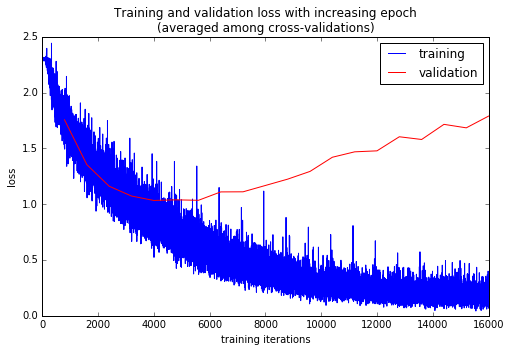

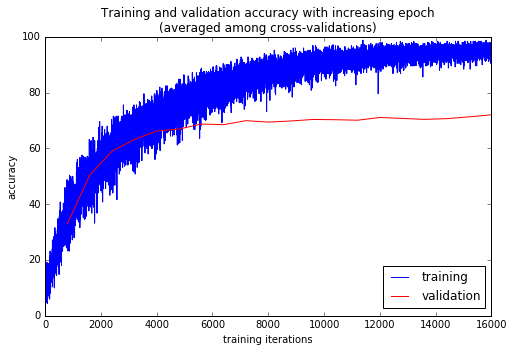

validation loss with increasing epoch (averaged among cross-validations):
[ 1.75614316  1.35461904  1.16112219  1.07319981  1.03346138  1.03912786
  1.03492783  1.11016655  1.11108651  1.16781349  1.22472855  1.29386127
  1.42076175  1.46929338  1.47810126  1.60426504  1.5799424   1.7154535
  1.68422125  1.7894979 ]
validation accuracy with increasing epoch (averaged among cross-validations):
[ 32.98   50.42   59.01   63.216  66.214  66.93   68.724  68.51   69.94
  69.434  69.82   70.374  70.282  70.104  71.084  70.756  70.404  70.666
  71.322  72.038]


In [44]:
avg_lossv_each_epoch=np.mean(loss_mat,axis=0) #mean of each column: mean loss among different cross-validations
avg_accv_each_epoch=np.mean(acc_mat,axis=0) #mean of each column: mean acc among different cross-validations

avg_lossv_train=np.mean(loss_mat_train,axis=0) #mean of each column: mean training loss among different cross-validations
avg_accv_train=np.mean(acc_mat_train,axis=0) #mean of each column: mean training acc among different cross-validations



plt.figure(figsize=(8,5))
plt.plot(train_iter_vector,avg_lossv_train, c='b',label="training")
# plt.plot(np.arange(1,valid_epochs+1), avg_lossv_each_epoch)
plt.plot(valid_iter_vector, avg_lossv_each_epoch, c='r',label="validation")
plt.title('Training and validation loss with increasing epoch\n(averaged among cross-validations)')
plt.xlabel('training iterations')
plt.ylabel('loss')
plt.legend()

plt.figure(figsize=(8,5))
plt.plot(train_iter_vector,avg_accv_train, c='b',label="training")
# plt.plot(np.arange(1,valid_epochs+1), avg_accv_each_epoch)
plt.plot(valid_iter_vector, avg_accv_each_epoch, c='r',label="validation")
plt.title('Training and validation accuracy with increasing epoch\n(averaged among cross-validations)');
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1, 0.2))

plt.show()

print("validation loss with increasing epoch (averaged among cross-validations):\n{}".format(avg_lossv_each_epoch))
print("validation accuracy with increasing epoch (averaged among cross-validations):\n{}".format(avg_accv_each_epoch))


### Training function

In [45]:
def train(epoch, model, optimizer, return_model=False, log_interval=100):
       
    model.train() # set the model to training mode
    
    for batch_idx, (data, target) in enumerate(train_loader): #get one batch in every iteration

        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad() #clear previous gradients
        output = model(data)

        loss = criterion(output, target)
        if l1_reg_weight!=0:
            """L1 regularization:"""
            L1_crit=nn.L1Loss(size_average=False) #sum up pairwise absolute loss, instead of averaging
            for param in model.parameters(): #for each parameter tensor
                all_0_target=torch.zeros(param.size())
                if cuda:
                    param,all_0_target=param.cuda(),all_0_target.cuda()
                all_0_target=Variable(all_0_target)
                #param=Variable(param) #param is already a Variable
                loss+=L1_crit(param,all_0_target)*l1_reg_weight

        #for plotting loss in each iteration.        
        lossv_train.append(loss.data[0])  # Never add loss directly! It's a tensor, so this will result in a memory waste

        #for plotting accuracy in each iteration
        pred = output.data.max(1)[1] 
        correct = pred.eq(target.data).cpu().sum() #The number of correct predictions of this batch
        accuracy = 100. * correct / batch_size #accuracy of this batch
        accv_train.append(accuracy)

        loss.backward() #Getting gradients w.r.t. parameters
        optimizer.step() #Update parameters

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    
    if return_model==True:        
        return model #Return the model after training is done

### Test function

In [ ]:
def test(loss_vector, accuracy_vector, model, return_conf_mat=False):
    model.eval() #what is this for?
    """
    Sets the module in evaluation mode.
    This has any effect only on modules such as Dropout or BatchNorm.
    """
    # make test data iterable
    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    test_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size, shuffle=True, **kwargs)

    if return_conf_mat==True:
        #The confusion matrix of test
        conf_mat=np.zeros((len(CLASSES),len(CLASSES))) #len(CLASSES)=10

    test_loss, correct = 0, 0
        
    for data, target in test_loader: #No enumerate(): one batch at a time, without index
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        """Volatile is recommended for purely inference mode, when you’re sure you won’t be even calling .backward(). 
        It’s more efficient than any other autograd setting - it will use the absolute minimal amount of memory 
        to evaluate the model. volatile also determines that requires_grad is False"""
        
        output = model(data)
        test_loss += criterion(output, target).data[0] #get data (Tensor) from variable, and get the first value of the Tensor
        pred = output.data.max(1)[1] # [1]: get the index of the max output (which corresponds to max log-probability), (1) means axis=1: row-wise max
        correct += pred.eq(target.data).cpu().sum() #The number of correct predictions: torch.eq() Computes element-wise equality
        
        target_array=target.data.cpu().numpy()
        pred_array=pred.cpu().numpy()
        #print("target_array.size: {}".format(target_array.size))
        if return_conf_mat==True:
            for i in range(batch_size):
                conf_mat[target_array[i],pred_array[i]]+=1 #in conf_mat: the row is the real class, the column is the predicted class
    
    test_loss /= len(test_loader) #Average loss among all test batches
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset) #total number of correct predictions
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    if return_conf_mat==True:
        return conf_mat

### Train on all training data and test with test data

In [ ]:
# Make training data iterable
train_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size, shuffle=True, **kwargs) 

#Build a new model for training
#model = NeuroNet(input_dim, output_dim) #instantiate a new model for each round of cross-validation
model = CNNModel() #instantiate a new model for each round of cross-validation
if cuda: #use GPU for model
    model.cuda()

#create a new optimizer for this round of cross-validation
optimizer=new_optim(model) # all other parameters of this function has default values which are the predefined hyperparams

#vectors used for plotting all test loss
lossv_test, accv_test = [], []
#vectors used for plotting all training loss along with all test loss, in order to check for overfitting
lossv_train=[]
accv_train=[]
train_iter_vector=np.arange(1,final_epochs*len(train_loader)+1)
test_iter_vector=np.arange(1*len(train_loader),final_epochs*len(train_loader)+1,len(train_loader)) #the index of training iteration when each test takes place

#final_epochs already initialized in the beginning, as one of the hyperparameters
for epoch in range(1, final_epochs + 1):
    if epoch==final_epochs:
        trained_model=train(epoch, model, optimizer, return_model=True) #return model in the last epoch
    else: 
        train(epoch, model, optimizer)

    if epoch==final_epochs:
        conf_mat=test(lossv_test, accv_test, model, return_conf_mat=True) #return confusion matrix of the last epoch
    else: 
        test(lossv_test, accv_test, model)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301096
Train Epoch: 1 [5000/50000 (10%)]	Loss: 2.306005
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.244911
Train Epoch: 1 [15000/50000 (30%)]	Loss: 2.116846
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.883024
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.854858
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.693806
Train Epoch: 1 [35000/50000 (70%)]	Loss: 2.103073
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.460467
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.666672

Test set: Average loss: 1.5821, Accuracy: 3980/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.717062
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.762052
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.460708
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.200441
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.506095
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.294046
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.693703
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.376364
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.363149
T

#### How many batches and examples in training and testing set, respectively

In [ ]:
print("Number of batches in training set: {}".format(len(train_loader)))
print("Number of examples in training set: {}\n".format(len(train_loader.dataset)))
print("Number of batches in testing set: {}".format(len(test_loader)))
print("Number of examples in tesing set: {}".format(len(test_loader.dataset)))

### Confusion matrix of the test result

In [ ]:
from pandas import DataFrame
confusion_matrix=DataFrame(conf_mat,columns=CLASSES,index=CLASSES)
print(confusion_matrix)
print("Rows represent the true classes, columns represent the predicted classes")

#### Plot the change of test loss and accuracy in each epoch

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,final_epochs+1), lossv_test)
plt.title('test loss')

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,final_epochs+1), accv_test)
plt.title('test accuracy');
plt.show()

print("Test losses (%): {}".format(lossv_test))
print("Test accuracies (%): {}".format(accv_test))

#### Calculate convergence time: with a predefined arbitrary threshold

In [ ]:
"""
Relative change of accuracy: the change of accuracy between 2 neighboring training epochs 
divided by the value of accuracy of the first training epoch, and define 2 criteria for convergence:
1. use 0.015 as the threshold, once this relative change of accuracy is below this threshold, 
then regard this as a convergence;
2. The std of one change value and the one before and the one after it should be lower than 
an arbitrary threshold: 0.01
--> which mean this relative change is both small enough and also the relative changes are quite stable after it
"""
acc_relative_change=[]
for i in range(len(accv_test)-1):
    acc_relative_change.append((accv_test[i+1]-accv_test[i])/accv_test[i]) #relative change of accuracy
for i in range(0,len(acc_relative_change)-3):
    consec_3_changes=np.array([acc_relative_change[i],acc_relative_change[i+1],acc_relative_change[i+2]])
    #print(np.std(consec_3_changes))
    if np.std(consec_3_changes)<0.01 and acc_relative_change[i]<0.015:
        print("The convergence time is {} training epochs".format(i+2)) #because i starts from 0
        break
    



#### Plot training loss (and accuracy) of all iterations, along with corresponding test loss (and accuracy) after each training epoch
For checking if there is overfitting

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(train_iter_vector, lossv_train, c='b',label="training")
plt.plot(test_iter_vector, lossv_test, c='r',label="test average")

axes = plt.gca()
axes.set_ylim([0,5])

plt.title('{}\nLoss in each training iteration along with corresponding average loss in test'.format(optim_type));
plt.xlabel('training iterations')
plt.ylabel('loss')
plt.legend()

plt.figure(figsize=(8,5))

plt.plot(train_iter_vector, accv_train, c='b',label="training")
plt.plot(test_iter_vector, accv_test, c='r',label="test average")

plt.title('{}\nAccuracy in each training iteration along with corresponding average loss in test'.format(optim_type));
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1, 0.2))

plt.show()


#### Save model

In [97]:
# #save the final model: after adjusting hyperparameters and doing cross-validation to choose the best combination of hyperparameters
# torch.save(trained_model.state_dict(), "model.3conv_4fc_1203_2025")

# del model
# del optimizer

#### Load saved models
And print all weights and biases of the model

In [16]:
the_model_0 = CNNModel() 
the_model_0.load_state_dict(torch.load("model.3conv_4fc_1203_2025")) 
# print(the_model_0)
# for param in the_model_0.parameters():
#     print(param.data)

## 5. Visualization of feature maps and filters
#### Visualize feature maps

Conv layer 1: feature maps before ReLU:


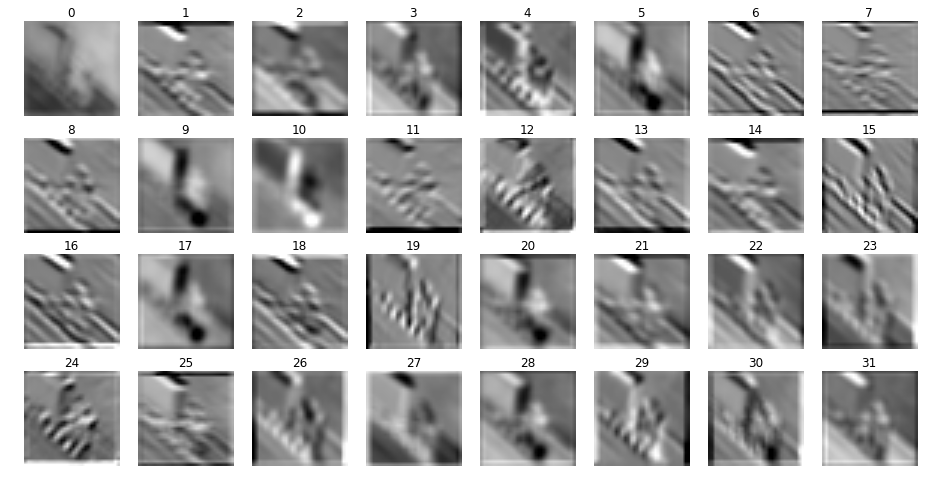

Conv layer 1: feature maps after ReLU


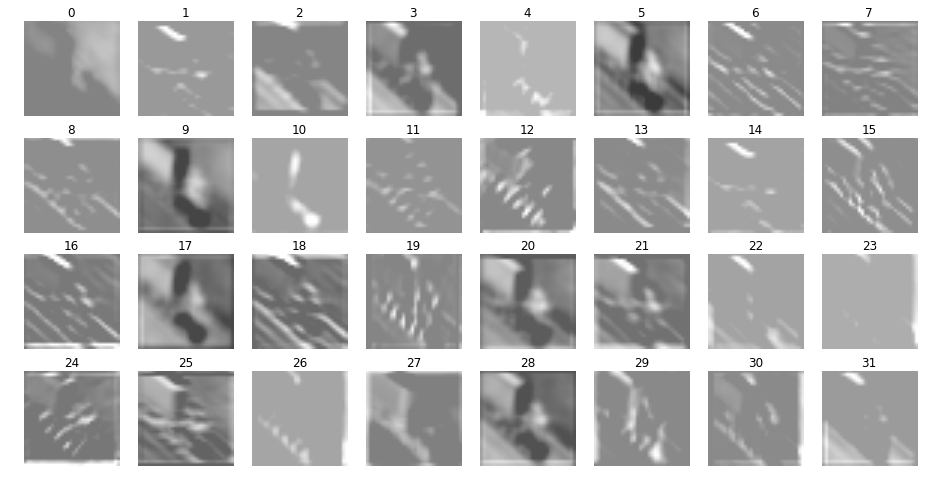

Conv layer 1: feature maps after pooling


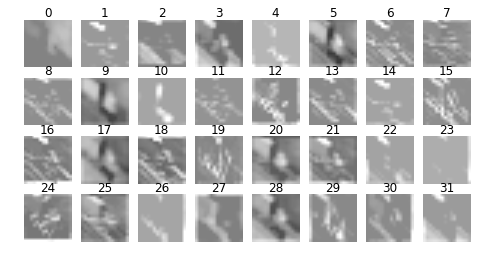

Conv layer 2: feature maps before ReLU:


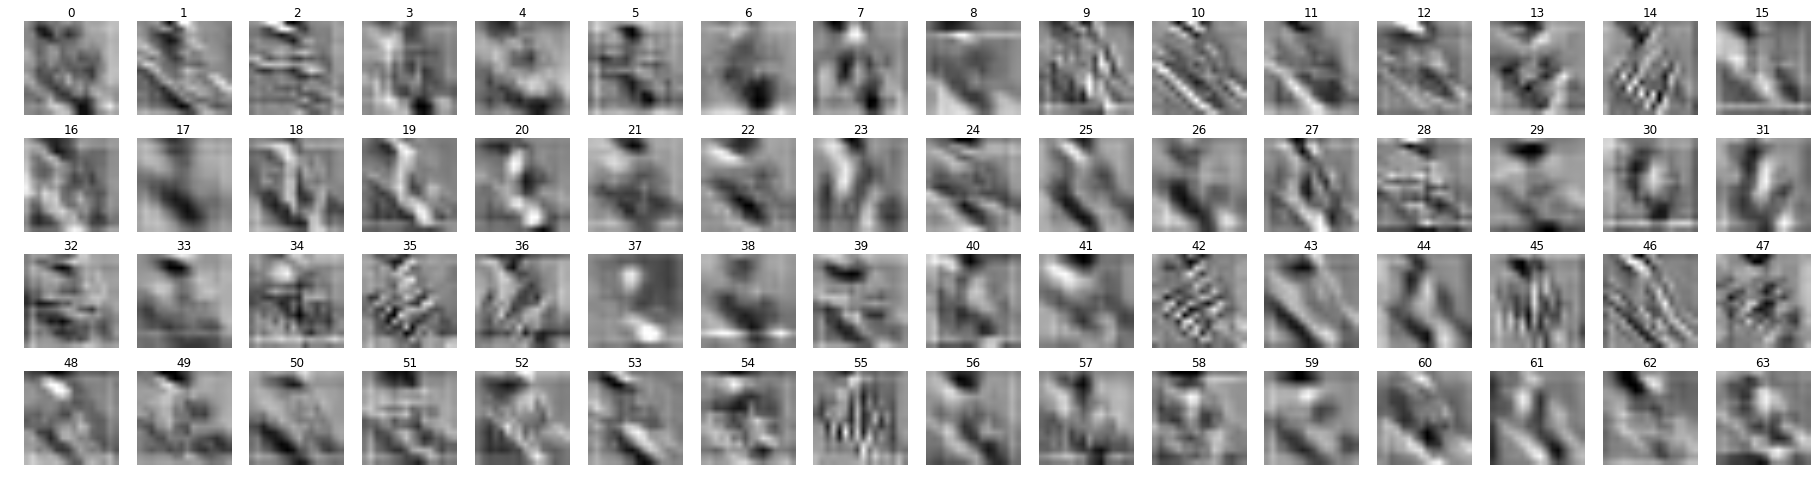

Conv layer 2: feature maps after ReLU


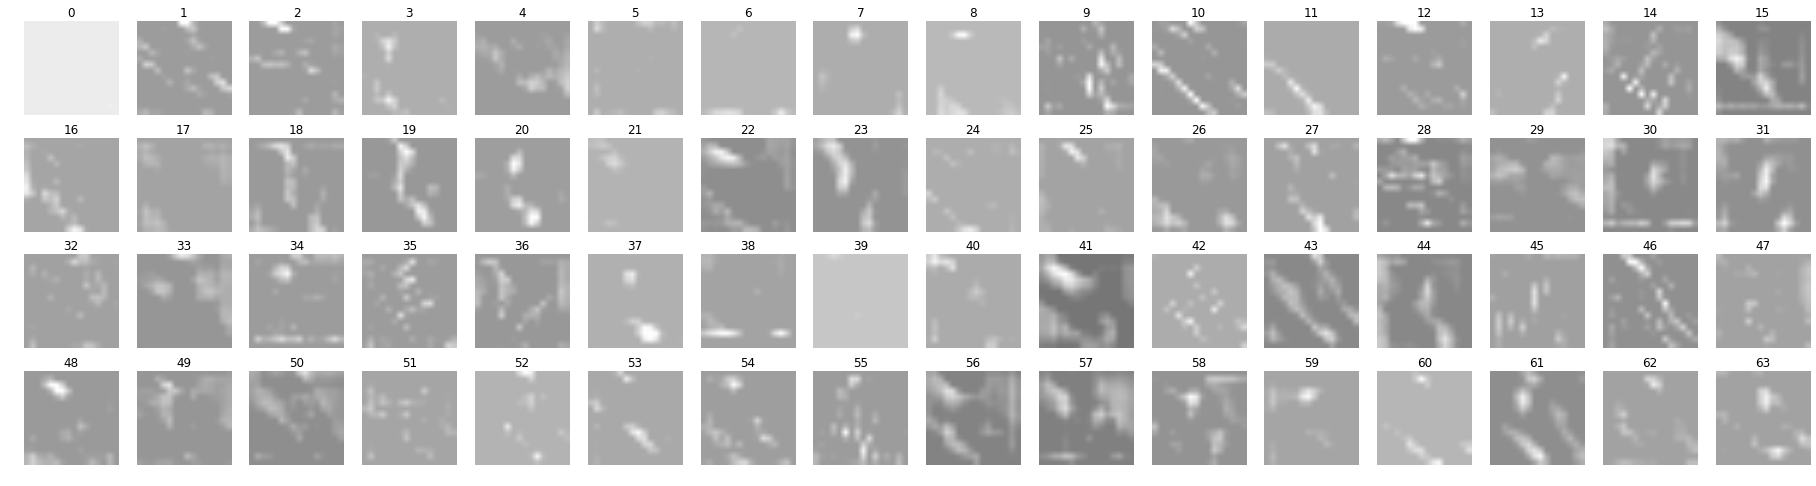

Conv layer 2: feature maps after pooling


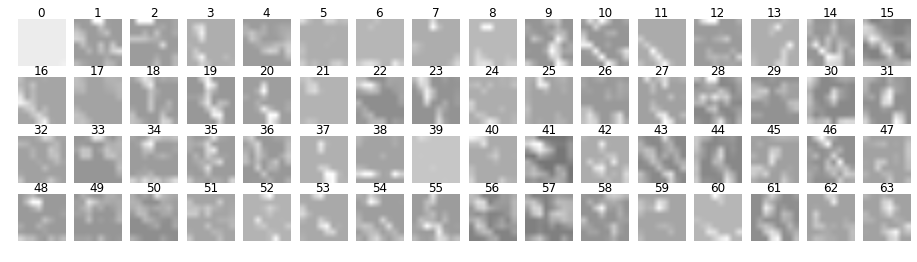

Conv layer 3: feature maps before ReLU:


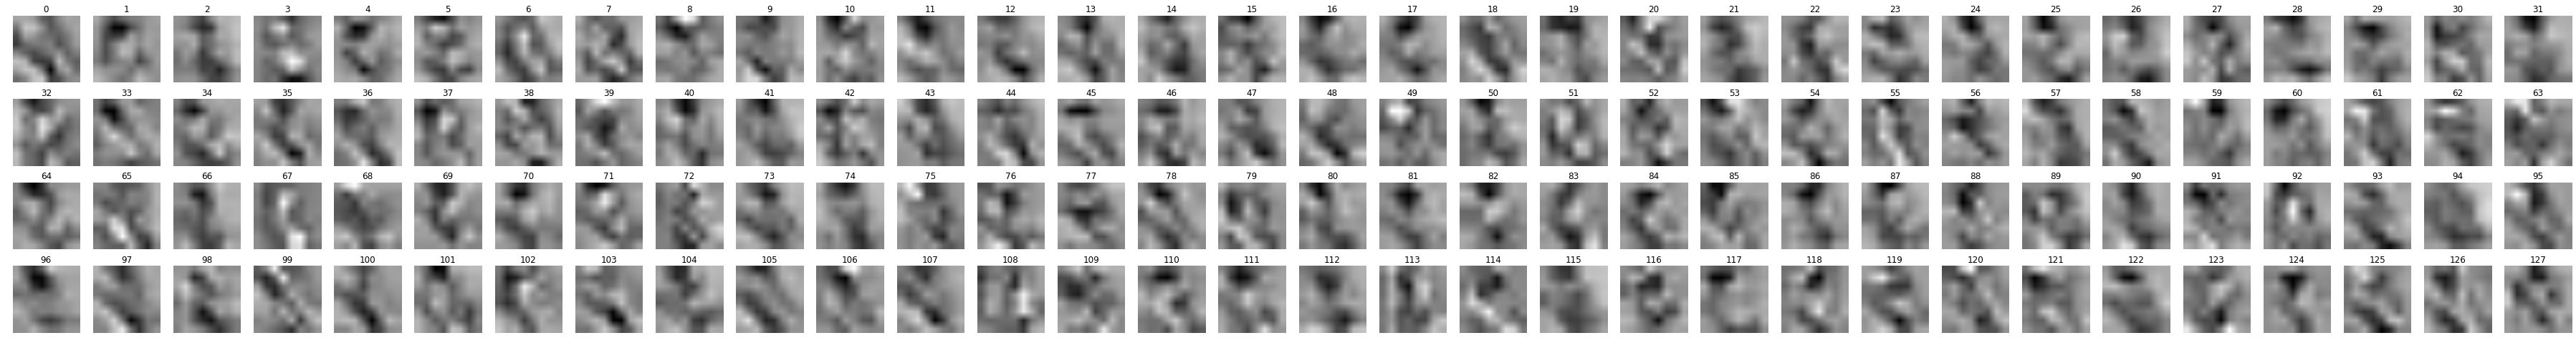

Conv layer 3: feature maps after ReLU


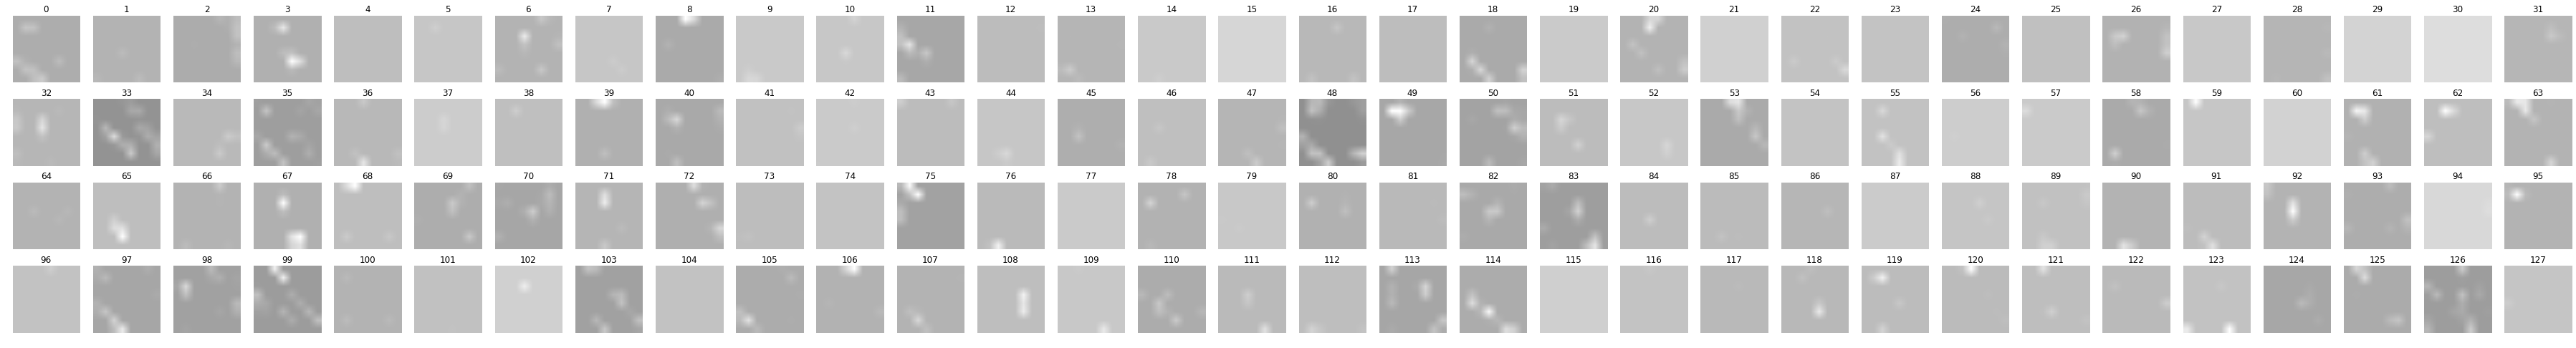

Conv layer 3: feature maps after pooling


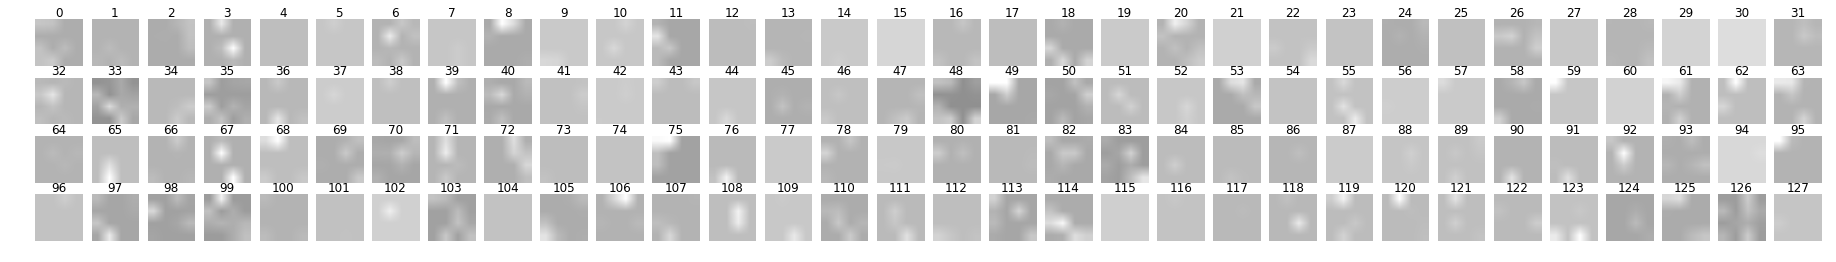

Variable containing:
 1.9596  0.4913 -1.4051  0.4474 -2.9392 -2.1368 -0.7236  0.1071 -0.8459  5.0461
[torch.FloatTensor of size 1x10]

In [17]:
img=trainset[50][0]
img=Variable(torch.unsqueeze(img,0)) #add one dimension to img
the_model_0.forward_imshow(img)

#### Visualize filters

In [18]:
for param in the_model_0.parameters():
    print(param.data)


(0 ,0 ,.,.) = 
 -7.9587e-02 -1.1993e-01 -1.8923e-01 -1.3756e-01 -1.1467e-01
 -5.6065e-02 -3.0754e-02 -5.2296e-02 -3.4757e-02 -9.6668e-02
  8.2873e-03  8.0379e-02  1.0748e-01  8.0224e-02 -8.8319e-02
  1.8340e-02  8.9509e-02  8.0876e-02  3.3995e-02 -7.4764e-02
 -6.7518e-02  2.3793e-02 -2.9813e-02 -4.5822e-02 -7.3451e-02

(0 ,1 ,.,.) = 
  2.2556e-01  1.8096e-01  9.4806e-02  1.1147e-01  1.3947e-01
  2.7569e-01  2.9850e-01  2.5576e-01  2.3664e-01  1.7257e-01
  3.0663e-01  3.8396e-01  3.9686e-01  3.4160e-01  1.7549e-01
  3.0057e-01  3.7059e-01  3.5624e-01  2.9811e-01  2.0221e-01
  2.2913e-01  3.0641e-01  2.4801e-01  2.2776e-01  2.2124e-01

(0 ,2 ,.,.) = 
 -3.7622e-02 -1.3557e-01 -2.0961e-01 -1.3439e-01 -1.7286e-03
 -2.0835e-01 -2.8875e-01 -3.1806e-01 -2.4482e-01 -1.5460e-01
 -3.1805e-01 -3.9294e-01 -3.8478e-01 -3.1682e-01 -2.7240e-01
 -3.0455e-01 -3.9999e-01 -4.2098e-01 -3.5490e-01 -2.2907e-01
 -1.9711e-01 -2.6013e-01 -3.2210e-01 -2.4163e-01 -6.6562e-02
     ⋮ 

(1 ,0 ,.,.) = 
  5.5280e-02 


 6.4574e-03  4.6445e-03  4.5532e-03  ...   1.9345e-02 -1.9980e-03  1.6393e-02
-1.5797e-03 -8.2450e-03  2.5287e-03  ...  -2.1936e-02 -8.5616e-03  4.3143e-03
 7.3004e-04 -3.6996e-03  6.3652e-03  ...  -8.3656e-03 -6.8639e-03  1.2107e-02
                ...                   ⋱                   ...                
-2.2384e-03  3.8861e-03  4.0554e-03  ...   9.5049e-03 -5.6751e-03 -1.3231e-03
 3.4565e-03  6.0102e-03 -5.3327e-03  ...   1.1017e-02 -1.3262e-02  1.8679e-02
-8.0091e-03  4.0396e-03  1.3526e-03  ...  -1.6195e-02  7.2692e-05 -2.9576e-03
[torch.FloatTensor of size 1000x2048]


-0.0478
-0.0240
-0.0457
   ⋮   
 0.0299
-0.0346
-0.0231
[torch.FloatTensor of size 1000]


-1.4385e-03  2.9299e-03  3.1359e-03  ...  -2.6851e-03  2.9459e-03  1.3966e-03
-4.5612e-03 -8.0315e-04 -7.2950e-04  ...  -3.8978e-03 -6.3446e-04  3.7405e-03
-1.9783e-03 -6.6444e-03 -1.1484e-03  ...  -3.4204e-04 -9.8143e-03 -2.6429e-03
                ...                   ⋱                   ...                
-1.3350e-0

In [ ]:
print(param.data[0][0])